In [1]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import pickle
import torch.nn as nn
import torch.optim as optim

In [3]:
class BeamDataset(Dataset):
    def __init__(self, folder):
        self.data = self.load_dataset(folder)
        print(len(self.data))
#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485],
#                                  std=[0.229])
#         ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        ## items from shape (2,54)-->(1,108) and (2,26)-->(1,52)
        input_data = self.data[index][0].reshape((1,108))
        label_data = self.data[index][1][0].reshape((1))
#         print(label_data)
#         input_data = self.transform(input_data)
        
        return input_data, label_data
        
    def load_dataset(self,folder):
        filename = os.path.join(folder, "dataset_dbeta_grads_only.pkl")
        
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        return data

def visualize_samples(dataset, indices, title=None, count=5):
    plt.figure(figsize=(count*3,15))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        input_data,_ = dataset[index]
        plt.subplot(count,1,i+1)
        plt.title("Trajectory x/y: %s" % index)
#         plt.plot(input_data[0],label='x')
#         plt.plot(input_data[1],label='y')
        plt.plot(input_data[0,:54],label='x')
        plt.plot(input_data[0,54:],label='y')
        plt.legend()
        plt.grid(False)
        plt.axis('on')  
        plt.subplots_adjust(hspace=0.5)
    

100000


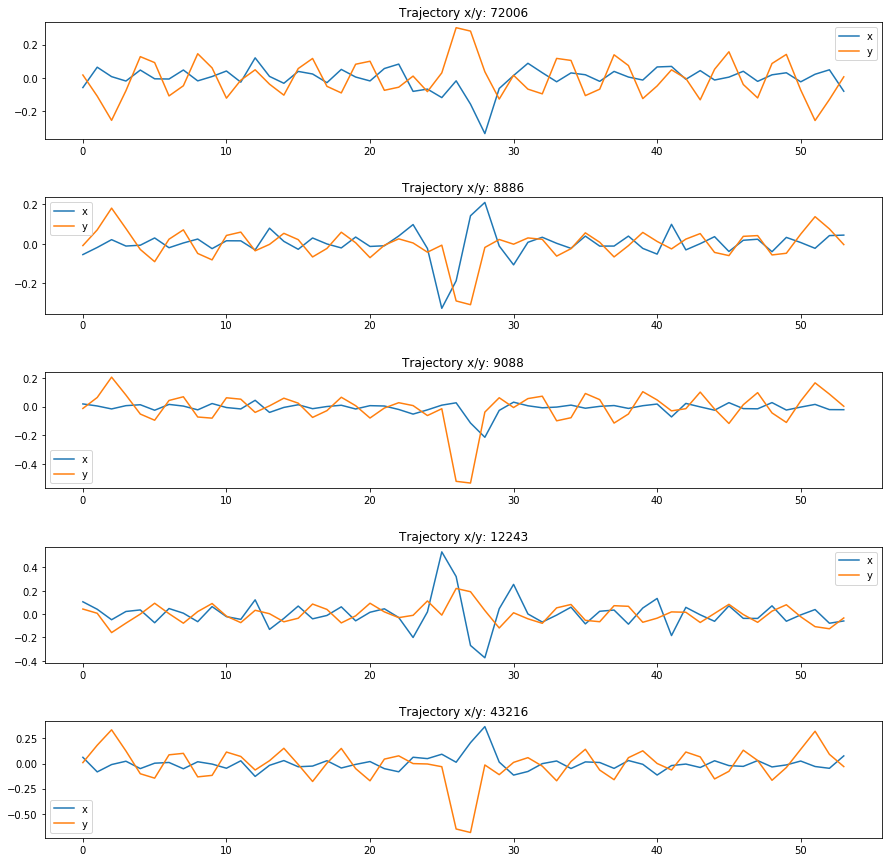

In [4]:
dataset = BeamDataset("")
indices = np.random.choice(np.arange(len(dataset)), 5, replace=False)
visualize_samples(dataset,indices)

In [13]:
batch_size = 32

data_size = len(dataset)
validation_fraction = .2

train_dataset = dataset


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [14]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [17]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    orbits = []
    ave_loss = 0
    for epoch in range(num_epochs):
        if np.mod(epoch,10) ==0:
            print(epoch)
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
             
#             x_gpu = x.to(device)
#             y_gpu = y.to(device)
            x_gpu = x
            y_gpu = y
#             print(x_gpu.shape)
            prediction = model(x_gpu)
            loss_value = loss(prediction,y_gpu)
#             loss_value = 0
#             for j in range(26):
#                 loss_value_per_one = loss(prediction[:,1,j], y_gpu[:,j])
#                 loss_value += loss_value_per_one
            
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
              
            comparison = torch.tensor([torch.allclose(prediction[i],y_gpu[i],rtol = 1e-1) for i in range(prediction.shape[0])])
            correct_samples += torch.sum(comparison == True)
            total_samples += y.shape[0]
            loss_accum += loss_value
#         print(i_step)
        if scheduler != None:
            scheduler.step()

        ave_loss = loss_accum/i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        
#         print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        print("Average loss: "+str(ave_loss.detach().cpu().numpy())+ ", Train accuracy: "+str(train_accuracy)+ ", Val accuracy: "+str(val_accuracy))
    orbits.append((prediction,y_gpu))  
    return loss_history, train_history, val_history, orbits
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    
    for i_step, (x, y) in enumerate(loader):
#         x_gpu = x.to(device)
#         y_gpu = y.to(device)
        x_gpu = x
        y_gpu = y

        prediction = model(x_gpu)    
            
        comparison = torch.tensor([torch.allclose(prediction[i],y_gpu[i],rtol = 1e-1) for i in range(prediction.shape[0])])
        correct_samples += torch.sum(comparison == True)
        total_samples += y.shape[0]
        
    accuracy = float(correct_samples) / total_samples
    return accuracy

In [22]:
nn_model = nn.Sequential(
            nn.Conv1d(1, 16, 3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32, 3),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(32),
            Flattener(),
#             nn.Linear(104,52),
            nn.Linear(3328,52),
            nn.ReLU(inplace=True),
            nn.Linear(52,1)
    
)
    
# nn_model.type(torch.cuda.DoubleTensor)
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
# loss = nn.L1Loss(reduction='sum').type(torch.cuda.DoubleTensor)
# loss = nn.MSELoss(reduction='sum').type(torch.cuda.DoubleTensor)
loss = nn.MSELoss(reduction='sum').type(torch.DoubleTensor)
# optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-3,momentum = 0.8)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9,verbose=True)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
0
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 0.14502549016789795, Train accuracy: 0.0009875, Val accuracy: 0.00185
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 0.00021222957619411898, Train accuracy: 0.027725, Val accuracy: 0.04745
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 4.4793987931811043e-07, Train accuracy: 0.040175, Val accuracy: 0.04615
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 3.889467568383369e-07, Train accuracy: 0.0418875, Val accuracy: 0.0979
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 2.428659993196474e-07, Train accuracy: 0.041325, Val accuracy: 0.02335
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 2.176144940416948e-06, Train accuracy: 0.039925, Val accuracy: 0.00385
Adjusting learning rate of group 0 to 1.0000e-03.
Average loss: 3.341837201238413e-05, Train accuracy: 0.034425, Val accuracy: 0.029
Adju

Average loss: 2.639810718466485e-07, Train accuracy: 0.0410375, Val accuracy: 0.0625
Adjusting learning rate of group 0 to 7.2900e-04.
Average loss: 2.662944810068631e-07, Train accuracy: 0.0403625, Val accuracy: 0.0242
Adjusting learning rate of group 0 to 7.2900e-04.
Average loss: 2.7064863341415816e-07, Train accuracy: 0.0406875, Val accuracy: 0.0638
Adjusting learning rate of group 0 to 7.2900e-04.
Average loss: 2.6818352739945787e-07, Train accuracy: 0.039325, Val accuracy: 0.07915
Adjusting learning rate of group 0 to 7.2900e-04.
Average loss: 2.61092209306314e-07, Train accuracy: 0.03905, Val accuracy: 0.0078
Adjusting learning rate of group 0 to 7.2900e-04.
Average loss: 2.667299293810071e-07, Train accuracy: 0.0404625, Val accuracy: 0.0164
Adjusting learning rate of group 0 to 7.2900e-04.
Average loss: 2.6815930777985594e-07, Train accuracy: 0.0395875, Val accuracy: 0.00925
Adjusting learning rate of group 0 to 7.2900e-04.
Average loss: 2.690118701716465e-07, Train accuracy: 0

Adjusting learning rate of group 0 to 5.3144e-04.
Average loss: 2.459305962394834e-07, Train accuracy: 0.0395375, Val accuracy: 0.0765
Adjusting learning rate of group 0 to 5.3144e-04.
Average loss: 2.4429017388725713e-07, Train accuracy: 0.04015, Val accuracy: 0.0043
Adjusting learning rate of group 0 to 5.3144e-04.
Average loss: 2.530570364775453e-07, Train accuracy: 0.0402125, Val accuracy: 0.04705
Adjusting learning rate of group 0 to 5.3144e-04.
Average loss: 2.463835883783906e-07, Train accuracy: 0.0403, Val accuracy: 0.0031
Adjusting learning rate of group 0 to 5.3144e-04.
Average loss: 2.4121477098372397e-07, Train accuracy: 0.0410125, Val accuracy: 0.0361
Adjusting learning rate of group 0 to 5.3144e-04.
Average loss: 2.459914739684563e-07, Train accuracy: 0.0409625, Val accuracy: 0.08405
Adjusting learning rate of group 0 to 5.3144e-04.
Average loss: 2.468268297489552e-07, Train accuracy: 0.0409625, Val accuracy: 0.0216
Adjusting learning rate of group 0 to 5.3144e-04.
Averag

KeyboardInterrupt: 

In [ ]:
nn_model = nn.Sequential(
#             nn.Conv1d(1, 2, 2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             nn.BatchNorm1d(1),
            
#             nn.Conv1d(1, 2, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
#             nn.BatchNorm1d(1),
    
#             nn.Conv1d(1, 1, 2, padding=1),
#             nn.Linear(28, 20,bias=True),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(1),
    
#             nn.Linear(20,2*26,bias=True),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(1),
            
#             nn.Linear(2*26,108,bias=True),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(1),
    
#             nn.Linear(108,52,bias=True),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm1d(1),
            
#             nn.Linear(52,26,bias=True)
    
            nn.Conv1d(1, 100, 3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(100),
            nn.Conv1d(100, 300, 3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(4),
            nn.BatchNorm1d(300),
            Flattener(),
#             nn.Linear(1, 100,bias=True),
#             nn.ReLU(inplace=True),
#             nn.Linear(100,52,bias=True),
#             nn.ReLU(inplace=True),
#             nn.Linear(52,108,bias=True),
#             nn.ReLU(inplace=True),
            nn.Linear(1800,300,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(300),
            nn.Linear(300,1,bias=True)
          )
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
loss = nn.L1Loss(reduction='sum').type(torch.DoubleTensor)
# loss = nn.MSELoss(reduction='mean').type(torch.DoubleTensor)
# optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e2)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8,verbose=True)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 1.3519672074535034, Train accuracy: 0.000475, Val accuracy: 0.00105
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.47854309195161654, Train accuracy: 0.0010125, Val accuracy: 0.0012
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.3512837114785599, Train accuracy: 0.0014625, Val accuracy: 0.0003
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.2615551567677977, Train accuracy: 0.00215, Val accuracy: 0.0002
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.2397162524054143, Train accuracy: 0.0024125, Val accuracy: 0.00405
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.21650654253297397, Train accuracy: 0.0031, Val accuracy: 0.0004
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.1856212027119254, Train accuracy: 0.0035625, Val accuracy: 0.00115
Adjusting learning rate of 

Adjusting learning rate of group 0 to 2.6214e-05.
Average loss: 0.009188921977292212, Train accuracy: 0.078125, Val accuracy: 0.0002
Adjusting learning rate of group 0 to 2.6214e-05.
Average loss: 0.009050162334221644, Train accuracy: 0.0750375, Val accuracy: 0.0006
Adjusting learning rate of group 0 to 2.6214e-05.
Average loss: 0.008966854578598384, Train accuracy: 0.0805875, Val accuracy: 0.0009
Adjusting learning rate of group 0 to 2.6214e-05.
Average loss: 0.00873502432483469, Train accuracy: 0.0839, Val accuracy: 5e-05
Adjusting learning rate of group 0 to 2.6214e-05.
Average loss: 0.007878680747801221, Train accuracy: 0.086975, Val accuracy: 0.0004
Adjusting learning rate of group 0 to 2.6214e-05.
Average loss: 0.008997112882265937, Train accuracy: 0.0776125, Val accuracy: 0.00115
Adjusting learning rate of group 0 to 2.6214e-05.
Average loss: 0.008115047273139848, Train accuracy: 0.0837125, Val accuracy: 5e-05
Adjusting learning rate of group 0 to 2.0972e-05.
Average loss: 0.007

In [9]:
nn_model = nn.Sequential(
            nn.Conv1d(1, 2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(1),
            
            nn.Conv1d(1, 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.BatchNorm1d(1),
    
            nn.Conv1d(1, 1, 2, padding=1),
            nn.Linear(28, 20,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1),
    
            nn.Linear(20,2*26,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1),
            
            nn.Linear(2*26,108,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1),
    
            nn.Linear(108,52,bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1),
            
            nn.Linear(52,26,bias=True)
          )
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
# loss = nn.L1Loss(reduction='sum').type(torch.DoubleTensor)
loss = nn.MSELoss(reduction='sum').type(torch.DoubleTensor)
# optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e2)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [71]:
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
# optimizer = optim.SGD(nn_model.parameters(), lr=1e2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 20,scheduler = scheduler)

Average Loss: 5.950797238620302
Average Loss: 5.924048934856038
Average Loss: 5.354370897207532
Average Loss: 5.33163831355085
Average Loss: 4.817250941504936
Average Loss: 4.798556986960074
Average Loss: 4.359815476016439
Average Loss: 4.318838352457157
Average Loss: 4.583071211058487
Average Loss: 3.897302231822754
Average Loss: 3.5170568429416202
Average Loss: 3.499282962536831
Average Loss: 3.154813090078494
Average Loss: 3.148406785905134
Average Loss: 2.8530507755848484


KeyboardInterrupt: 

In [110]:
nn_model = nn.Sequential(
            nn.Conv1d(1, 2, 2, padding=1),
            nn.BatchNorm1d(1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv1d(1, 2, 3, padding=1),
            nn.BatchNorm1d(1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv1d(1, 1, 2, padding=1),
            nn.BatchNorm1d(1),
            nn.Linear(108, 100,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100,200,bias=True),
            nn.ReLU(inplace=True),
#             nn.Linear(200,108,bias=True),
#             nn.ReLU(inplace=True),
            nn.Linear(108,52,bias=True),
#             nn.ReLU(inplace=True),
#             nn.Linear(54,52,bias=True)
          )
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
loss = nn.L1Loss(reduction='sum').type(torch.DoubleTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

RuntimeError: running_mean should contain 2 elements not 1

In [105]:
nn_model = nn.Sequential(
            nn.Conv1d(1, 32, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv1d(8, 64, 4, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv1d(16, 48, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv1d(12, 1, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(1),
            nn.Linear(1, 100,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(100,52,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(52,108,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(108,52,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(52,52,bias=True)
          )
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
loss = nn.L1Loss(reduction='sum').type(torch.DoubleTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e1, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

Average Loss: 7.808318138698853e+100
Average Loss: 2713090.320978401
Average Loss: 1356555.3265317394
Average Loss: 1356558.9731922457
Average Loss: 678280.6433822318
Average Loss: 678281.0341552884
Average Loss: 339140.637364004
Average Loss: 339140.6694595402
Average Loss: 169570.34362025096
Average Loss: 169570.3443678971
Average Loss: 84785.17175896614
Average Loss: 84785.17067305489
Average Loss: 48988.09312155154
Average Loss: 42391.34770147594
Average Loss: 21195.67453997224
Average Loss: 21195.675192627245
Average Loss: 10597.836828127278
Average Loss: 10597.837209087807
Average Loss: 5298.919246853424
Average Loss: 5298.919266720462
Average Loss: 2679.3241780435715
Average Loss: 2649.458709561391
Average Loss: 1515.6386739500383
Average Loss: 1324.7277917228669
Average Loss: 662.3637555040839
Average Loss: 662.3637492575293
Average Loss: 331.7436500775459
Average Loss: 331.1820735162
Average Loss: 173.57651932516578
Average Loss: 165.59060957363874
Average Loss: 85.66110769989

In [61]:
nn_model = nn.Sequential(
            nn.RNN(108,100,1),
            
            nn.Linear(100,52,bias=True)
          )
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
loss = nn.L1Loss(reduction='sum').type(torch.DoubleTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e1, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

torch.Size([1, 100, 108])
<built-in method type of Tensor object at 0x000001F8A67AD818>


TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple

In [35]:
nn_model = nn.Sequential(
            nn.BatchNorm1d(1),
            nn.Conv1d(1, 14, 7, padding=0),
            nn.Conv1d(14, 2, 7, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
#             nn.Conv1d(1, 1, 2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            Flattener(),
            nn.Linear(96, 20,bias=True),
            nn.ReLU(inplace=True),
#             nn.Linear(20,2*26,bias=True),
#             nn.ReLU(inplace=True),
#             nn.Linear(2*26,108,bias=True),
#             nn.ReLU(inplace=True),
#             nn.Linear(108,52,bias=True),
#             nn.ReLU(inplace=True),
            nn.Linear(20,1,bias=True)
          )
nn_model.type(torch.DoubleTensor)
# nn_model.to(device)

# loss = nn.L1Loss().type(torch.cuda.FloatTensor) -->
loss = nn.L1Loss(reduction='sum').type(torch.DoubleTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7,verbose=True)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=3, threshold=0.000001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
loss_history, train_history, val_history,orbits = train_model(nn_model, train_loader, val_loader, loss, optimizer, 200,scheduler = scheduler)

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.1366705575494082, Train accuracy: 0.0029375, Val accuracy: 0.00195
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.07876678480914995, Train accuracy: 0.0028375, Val accuracy: 0.00315
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.06847442338961586, Train accuracy: 0.002475, Val accuracy: 0.00065
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.06305875370909221, Train accuracy: 0.0021, Val accuracy: 0.00105
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.05969972026272544, Train accuracy: 0.0019375, Val accuracy: 0.0017
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.057995301336866686, Train accuracy: 0.0019375, Val accuracy: 0.00075
Adjusting learning rate of group 0 to 1.0000e-04.
Average loss: 0.05726886306120342, Train accuracy: 0.0016, Val accuracy: 0.00035
Adjusting learning r

KeyboardInterrupt: 

In [101]:
pred,gt = orbits[0]
a = pred.detach().numpy()[0]
b = gt.detach().numpy()[0]
print("pred",a[0,:54])
print("gt",b[0,:54])
# plt.plot(a[0,:54])
# plt.hist(10**6*b[0,:54],8)
# plt.show()
# plt.hist(10**6*a[0,:54],8)
# plt.show()


pred [-5.35969519e-14 -3.93323865e-14 -5.62036798e-14 -2.63367723e-14
  2.37253492e-14 -1.32095710e-14 -4.11888779e-16 -6.35117354e-14
 -1.59625998e-16 -9.69795107e-17  3.98703296e-14  3.64950648e-14
  3.33882560e-14 -2.20000948e-16  5.54247966e-14 -4.58224722e-14
  2.03372480e-14 -3.93765928e-14 -1.59468393e-15  5.12044419e-14
  5.03585709e-14 -5.15294943e-14  5.83761515e-14 -4.21590894e-14
  4.14194265e-14  3.37713908e-14 -4.50919063e-16 -1.92970781e-14
 -1.51371612e-14  7.67726708e-15  1.75152532e-14  2.08460818e-14
 -2.97078041e-14 -2.80852201e-14  1.89771114e-14 -1.48018314e-14
  3.92310124e-15 -1.54566096e-14  9.69476852e-16  1.09841445e-14
  1.83558684e-14  2.02019070e-14  1.57393367e-14 -1.98248504e-14
  2.03528429e-14 -2.06240597e-14 -3.39731253e-14  6.86814632e-15
 -6.09418170e-15 -1.59105472e-14 -3.19363329e-15 -2.21260325e-15]
gt [ 3.19343571e-10  1.62057354e-10  3.26131869e-10  8.37040934e-11
 -7.03061783e-11  3.31346306e-11  9.79348710e-12  4.60236020e-10
  3.34228102e-12

In [180]:
a = np.array([[1,2],[3,4]]).T
print(a.flatten())

[1 3 2 4]


In [63]:
torch.randn(2,2,2)

tensor([[[-0.0609,  0.4936],
         [ 0.1370,  0.2416]],

        [[ 0.0776, -0.5646],
         [ 0.1650,  1.6516]]])